In [1]:
import numpy as np
from scipy.stats import geom
from itertools import product
from quantecon import MarkovChain
from quantecon import compute_fixed_point
from quantecon.distributions import BetaBinomial
from quantecon.markov import tauchen
import quantecon as qe
from numba import njit
from collections import namedtuple
import matplotlib.pyplot as plt

# Q1

## (a) Write down the appropriate Bellman Equation.


Denote $o=0,1$ to be a state indictating whether there is a wage offer at time t. And let $v\left(o,w\right)$ to be the value function given the latent wage offer $w$ and the arrival of wage offer $o$.

$$
v\left(0,w\right)=c+\beta\left[\sum_{w^{\prime}}\left(\left(1-\gamma\right)v\left(0,w^{\prime}\right)+\gamma v\left(1,w^{\prime}\right)\right)\right]
$$

$$
v\left(1,w\right)=\max\left\{ \frac{w}{1-\beta},c+\beta\left[\sum_{w^{\prime}}\left(\left(1-\gamma\right)v\left(0,w^{\prime}\right)+\gamma v\left(1,w^{\prime}\right)\right)\right]\right\} 
$$

## (b) How should the reservation wage vary with $γ$? Why?

The reservation wage conditional on the arrival of an offer will be increasing in $\gamma$, since the workers will be more selective when it is easy to receive wage offers. 

## (c) Solve the model computationally for a generic γ

First, define q `namedtuple` to characterize the problem. There will be an additional attribute `γ` compared to the infinite horizon model with probability one for receiving an offer.

In [2]:
# NamedTuple Model
ModelA = namedtuple("ModelA", ("n", "w_vals", "φ", "β", "c", "γ"))


def create_model_a(
        n=50,        # wage grid size
        w_min=10.0,  # lowest wage
        w_max=60.0,  # highest wage
        a=200,       # wage distribution parameter
        b=100,       # wage distribution parameter
        β=0.96,      # discount factor
        c=10.0,      # unemployment compensation
        γ=1.         # probability of wage offer arrival
    ):
    """
    Creates the parameters for job search model and returns the
    instance of namedtuple Model
    """
    w_vals = np.linspace(w_min, w_max, n+1)
    φ = BetaBinomial(n, a, b).pdf()
    return ModelA(n=n, w_vals=w_vals, φ=φ, β=β, c=c, γ=γ)

In [3]:
model_a = create_model_a()

In [4]:
@njit
def T_a(v, model):
    """ The Bellman operator. """

    # unpack model parameters
    n, w_vals, φ, β, c, γ = model

    # initialize a new v array
    v_new = np.empty_like(v)

    # continuation value
    cont_val = c + β * np.sum(((1-γ) * v[0, :] + γ * v[1, :]) * φ)

    # update v(w, 0)
    v_new[0, :] = cont_val

    # update v(w, 1)
    stop_vals = w_vals / (1 - β)
    v_new[1, :] = np.maximum(stop_vals, cont_val)

    return v_new

In [5]:
def vfi_a(model):
    """ Solve the infinite-horizon IID job search model by VFI. """
    v_init = np.zeros((2, model.w_vals.size))
    v_star = compute_fixed_point(lambda v: T_a(v, model), v_init,
                                 error_tol=1e-5, max_iter=1000,
                                 verbose=0)
    return v_star

In [6]:
v_star = vfi_a(model_a)

Note that we set the default value of $\gamma$ to be 1. We should verify that using the new and more generic method iterates to the same value function as we have seen in the class.

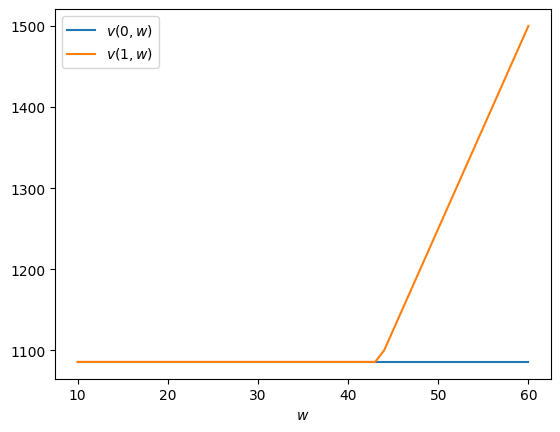

In [7]:
plt.plot(model_a.w_vals, v_star.T)

plt.legend(['$v(0,w)$', '$v(1,w)$'])
plt.xlabel('$w$')

plt.show()

In [8]:
@njit
def res_wage_a(v, model):
    """
    compute the reservation wage given the arrival
    of a wage offer
    """

    # unpack model parameters
    n, w_vals, φ, β, c, γ = model

    # continuation value
    cont_val = c + β * np.sum(((1-γ) * v[0, :] + γ * v[1, :]) * φ)

    # reservation wage
    res_w = (1 - β) * cont_val

    return res_w

Compute the reservation wage when $\gamma=1$

In [9]:
res_wage_a(v_star, model_a)

43.429715785853155

## (d) Plot how the reservation wage varies with $\gamma$ for $\gamma= 0.1, 0.2, .....0.9, 1$

First, let's generate the sequence of $\gamma$ and we will find out the reservation wage conditional the arrival of wage offer on each $\gamma$ grid point.

In [10]:
γ_arr = np.arange(0.1, 1.1, 0.1)

γ_arr

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

We also prepare a container array for the reservation wages to compute.

In [11]:
res_w_arr = np.empty_like(γ_arr)

The steps will be 

1. iteratve over $\gamma$ values
2. create a `ModelA` instance with the $\gamma$ value
3. compute the corresponding value function
4. find out the reservation wage

In [12]:
for i, γ in enumerate(γ_arr):
    model_γ = create_model_a(γ=γ)

    v_star = vfi_a(model_γ)

    res_w_arr[i] = res_wage_a(v_star, model_γ)

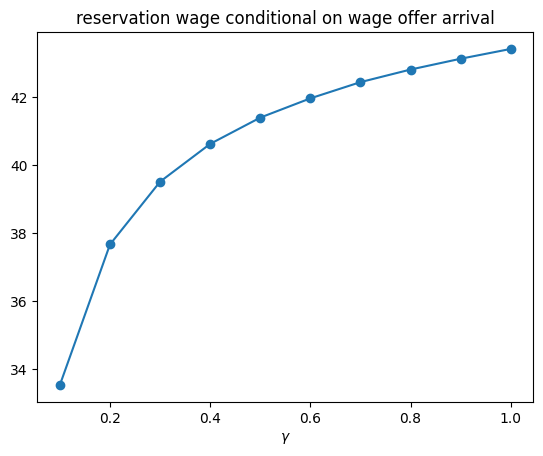

In [13]:
plt.plot(γ_arr, res_w_arr, 'o-')

plt.xlabel('$γ$')
plt.title('reservation wage conditional on wage offer arrival')

plt.show()

# Q2

## (a) Write down the appropriate Bellman Equation.


Let $v\left(e,w\right)$ be the value function, where $e=0,1$ indicates the efficiency state. The Bellman equation is given by

$$
v\left(e,w\right)=\max\left\{ \frac{\left(1+0.5e\right)w}{1-\beta},c+\beta\sum_{w^{\prime},e^{\prime}}v\left(e^{\prime},w^{\prime}\right)P\left(w^{\prime},e^{\prime}\mid w,e\right)\right\} 
$$

Note that given the independence between $w$ and $e$

$$
\sum_{w^{\prime},e^{\prime}}v\left(e^{\prime},w^{\prime}\right)P\left(w^{\prime},e^{\prime}\mid w,e\right)	=\sum_{w^{\prime}}\left[P_{e}\left(e^{\prime}=0\mid e\right)v\left(0,w^{\prime}\right)+P_{e}\left(e^{\prime}=1\mid e\right)v\left(1,w^{\prime}\right)\right]P_{w}\left(w^{\prime}\mid w\right)
$$

## (b) Is the reservation wage the same in both efficiency states? Why or why not?

The reservation wage will be different conditional on different efficiency states.

This is becasue that not only the stopping value will be dependent on the current efficiency, but also the continuation value will be different as the conditional distribution over $e^\prime$ will be different.

Therefore, the reservation wage, which is the critical value that equates the stopping value and the continuation value, will be dependent on the efficiency state.

Intuitively, the reservation (latent) wage will be lower at the higher efficiency state.

## (c) solve the model computationally and obtain the reservation wages for each efficiency state (or the single reservation wage if you think there is only one)

In [14]:
ModelB = namedtuple("ModelB", ("n", "w_vals", "Pw", "Pe", "β", "c"))

def create_model_b(
        n=200,       # wage grid size
        ρ=0.9,       # wage persistence
        ν=0.2,       # wage volatility
        β=0.98,      # discount factor
        c=1.0,       # unemployment compensation
        λ0=0.6,      # prob. e=0 to e'=0
        λ1=0.8,      # prob. e=1 to e'=1
        n_std=3      # tauchen approximation parameter
    
    ):
    """
    Creates an instance of the job search model with Markov wages.
    """
    mc = tauchen(n, ρ, ν, n_std=n_std)
    w_vals, Pw = np.exp(mc.state_values), mc.P

    Pe = np.array([[λ0, 1-λ0],
                   [1-λ1, λ1]])
    return ModelB(n=n, w_vals=w_vals, Pw=Pw, Pe=Pe, β=β, c=c)

In [15]:
model_b = create_model_b()

In [16]:
@njit
def T_b(v, model):
    """ The Bellman operator. """

    # unpack model parameters
    n, w_vals, Pw, Pe, β, c = model

    # initialize a new v array
    v_new = np.empty_like(v)

    # iterate over the current e=0,1
    for e in range(2):
        # stopping value
        stop_vals = w_vals * (1 + 0.5 * e) / (1 - β)

        # continuation value
        cont_vals = c + β * Pw @ (v.T @ Pe[e])

        # update v(w, e)
        v_new[e, :] = np.maximum(stop_vals, cont_vals)

    return v_new

In [17]:
def vfi_b(model):
    v_init = np.zeros((2, model.w_vals.size))
    v_star = compute_fixed_point(lambda v: T_b(v, model), v_init,
                                 error_tol=1e-5, max_iter=1000,
                                 verbose=0)
    return v_star

In [18]:
v_star = vfi_b(model_b)

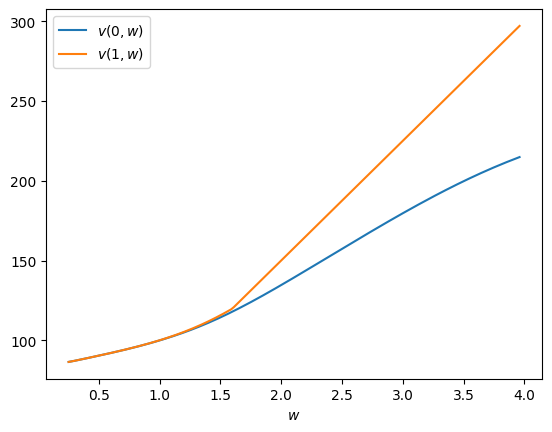

In [19]:
plt.plot(model_b.w_vals, v_star.T)

plt.legend(['$v(0,w)$', '$v(1,w)$'])
plt.xlabel('$w$')

plt.show()

In [20]:
def plot_res_w(v, model):
    n, w_vals, Pw, Pe, β, c = model

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    for e in range(2):
        axs[e].plot(w_vals, c + β * Pw @ (v.T @ Pe[e]))
        axs[e].plot(w_vals, w_vals * (1 + 0.5 * e) / (1-β))
        axs[e].legend(['$cont.$', '$stop$'])
        axs[e].set_xlabel('$w$')
        axs[e].set_title(f'e={e}')

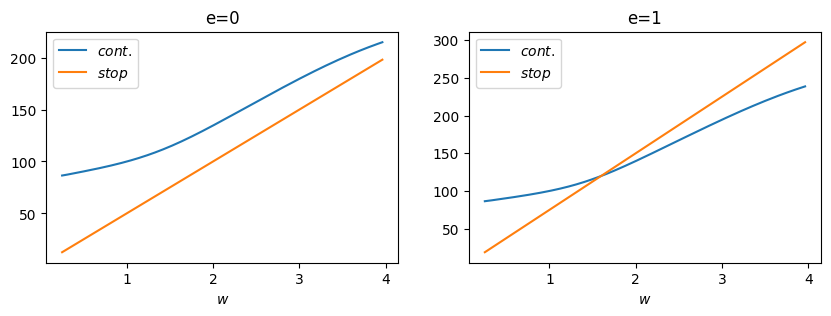

In [21]:
plot_res_w(v_star, model_b)

In [22]:
@njit
def res_wage_b(v, model):
    """
    compute the reservation wage for each efficiency
    """

    # unpack model parameters
    n, w_vals, Pw, Pe, β, c = model

    # reservation wages for e=0,1
    res_w = np.empty(2)
    res_w[:] = np.inf

    # iterate over the current e=0,1
    for e in range(2):
        # stopping value
        stop_vals = w_vals * (1 + 0.5 * e) / (1 - β)

        # continuation value
        cont_vals = c + β * Pw @ (v.T @ Pe[e])

        for i in range(w_vals.size):
            if stop_vals[i] > cont_vals[i]:
                res_w[e] = w_vals[i]
                break

    return res_w

In [23]:
res_wage_b(v_star, model_b)

array([       inf, 1.61167974])

The reservation wage at the low efficiency state is given by `np.inf`. This is simply because the maximum value of the wage grid is smaller than the actual reservation wage.

To resolve this issue, we can increase `n_std` parameter in the tauchen approximation and therefore expand the wage grid to include the reservation wage at the low efficiency state.

## (c*)

We increase `n_std` for the `tauchen` method, so that the resulted `w_vals` for approximation contains higher values of `w`.

In [24]:
model_b = create_model_b(n_std=5)

model_b.w_vals.max()

9.916076596761835

In [25]:
v_star = vfi_b(model_b)

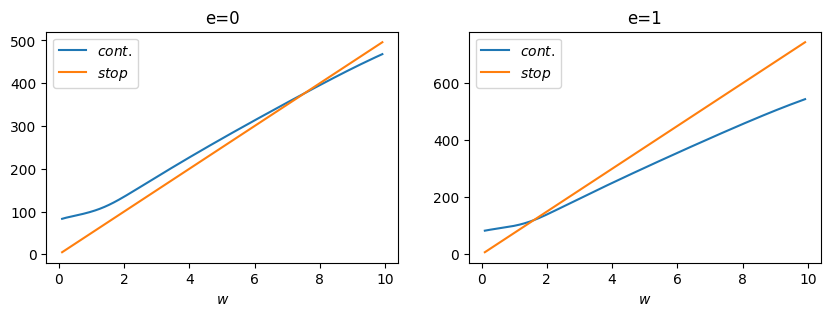

In [26]:
plot_res_w(v_star, model_b)

In [27]:
res_wage_b(v_star, model_b)

array([7.69470095, 1.6042648 ])

The reservation wage at $e=0$ is now correctly computed.

Compare the reservation wage at $e=1$ with `n_std=3` versus `n_std=5`. Does it change? If so, why?

# Q3

## (a) Write down the appropriate Bellman Equation.

Let $v_{e}(w)$ be the value function of employment, and $v_u(t, w)$ be the value function of unemployment, and $t \geq 1$ is the number of periods of unemployment.

$$
v_{e}\left(w\right)=w+\beta\left[\alpha\sum_{w^{\prime}}v_{u}\left(1,w^{\prime}\right)P\left(w,w^{\prime}\right)+\left(1-\alpha\right)v_{e}\left(w\right)\right]
$$

$$
v_{u}\left(t,w\right)=\max\left\{ v_{e}\left(w\right),\frac{c}{2}+\frac{c}{2}\boldsymbol{1}\left\{ t\leq T_c\right\} +\beta\sum_{w^{\prime}}v_{u}\left(t+1,w^{\prime}\right)P\left(w,w^{\prime}\right)\right\} 
$$

Note that $v_{u}\left(t,w\right)=v_{u}\left(t+1,w\right)=v_{u}\left(T_c+1,w\right)$ for all $t > T_c$.

## (b) Does the reservation wage varies over a spell of unemployment? Why or why not?

The reservation wage will decrease as unemployment continues.

This is because the future flow of unemployment conpensation will decline as the number of unemployment periods approachs $T_c$, which makes staying in unemployment less "attractive" to the worker.

As a consequence, the worker will be less selective and more willing to accept a wage offer.

However, the declining trend will stop at $T_c$ and the reservation wage will stay constant for all $t>T_c$.

## (c) Solve the model computationally

Let's work on a combined value function array $[v_e(w), v_u(t,w)]$.

We expand the state vector for value function of employment to be $(t,w)$ as well, and $t=0$ indicates that the worker is employed.

We will iterate the value function array $v(t,w)$ to convergence. In each iteration, we will update the following $3$ components in the combined value function array.

1. $v(0,w) \equiv v_e(w)$
2. $v(t,w) \equiv v_u(t,w)$ for $1\leq t \leq T_c$
3. $v(T_c+1,w) \equiv v_u(t,w)$ for $t>T_c$

The size of value function array will be of `(Tc+2, len(w_vals))`

In [28]:
# NamedTuple Model
ModelC = namedtuple("ModelC", ("n", "w_vals", "P", "β", "c", "α", "Tc"))


def create_model_c(
        n=200,          # wage grid size
        ρ=0.9, ν=0.2,   # wage persistence and volatility
        β=0.98, α=0.1,  # discount factor and separation rate
        c=1.0, Tc=24):  # unemployment compensation
    """Creates an instance of the job search model with separation."""
    mc = tauchen(n, ρ, ν)
    w_vals, P = np.exp(mc.state_values), mc.P
    return ModelC(n=n, w_vals=w_vals, P=P, β=β, c=c, α=α, Tc=Tc)

In [29]:
model_c = create_model_c()

In [30]:
@njit
def T_c(v, model):
    """ The Bellman operator. """

    # unpack model parameters
    n, w_vals, P, β, c, α, Tc = model

    # initialize a new v array
    v_new = np.empty_like(v)

    # update v(0,w)≡v_e(w)
    v_new[0, :] = w_vals + β * (α * P @ v[1, :] + (1 - α) * v[0, :])

    # update v(t,w)≡v_u(t,w) for t between 1 and Tc
    # note that index t on the left, and t+1 on the right
    for t in range(1, Tc+1, 1):
        v_new[t, :] = np.maximum(v[0, :],
                                 c + β * (P @ v[t+1, :]))

    # update v(Tc+1, w)≡v_u(Tc+1,w)
    # note that index Tc+1 on both left and right
    v_new[Tc+1, :] = np.maximum(v[0, :],
                                c/2 + β * (P @ v[Tc+1, :]))

    return v_new

In [31]:
def vfi_c(model):
    v_init = np.zeros((model.Tc+2, model.w_vals.size))
    v_star = compute_fixed_point(lambda v: T_c(v, model), v_init,
                                 error_tol=1e-5, max_iter=1000,
                                 verbose=0)
    return v_star

In [32]:
v_star = vfi_c(model_c)

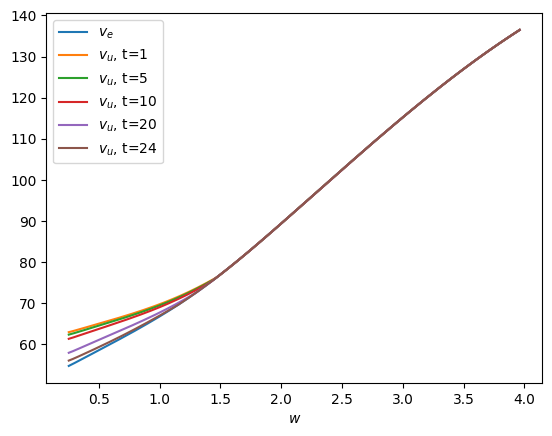

In [33]:
t_arr = [1, 5, 10, 20, model_c.Tc]

plt.plot(model_c.w_vals, v_star[0])
plt.plot(model_c.w_vals, v_star[t_arr].T)

plt.legend(['$v_e$'] + [f'$v_u$, t={t}' for t in t_arr])

plt.xlabel('$w$')
plt.show()

In [34]:
@njit
def res_wage_c(v, model):
    """
    compute the reservation wage at each period of unemployment
    """

    # unpack model parameters
    n, w_vals, P, β, c, α, Tc = model

    # reservation wages for t=1,2,...,Tc,Tc+1
    res_w = np.empty(Tc+1)
    res_w[:] = np.inf

    # iterate over t=1,...,Tc
    for t in range(1, Tc+1, 1):
        cont_vals = c + β * (P @ v[t+1, :])
        for i in range(w_vals.size):
            if v[0, i] > cont_vals[i]:
                res_w[t-1] = w_vals[i] # note the index t-1
                break

    # for t=Tc+1, conpensation is c/2
    cont_vals = c/2 + β * (P @ v[Tc+1, :])
    for i in range(w_vals.size):
        if v[0, i] > cont_vals[i]:
            res_w[Tc] = w_vals[i]
            break

    return res_w

In [35]:
res_w_arr = res_wage_c(v_star, model_c)

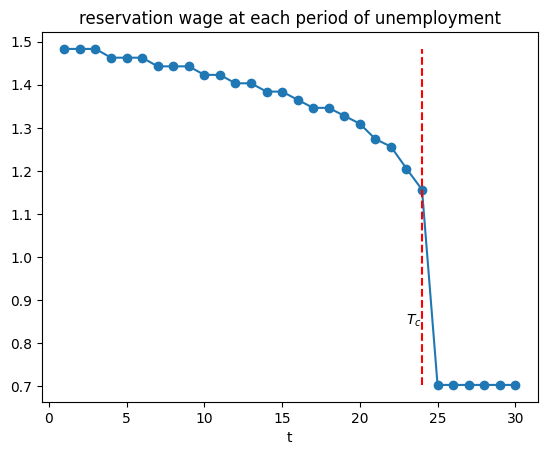

In [36]:
res_w_30 = np.empty(30)

Tc = model_c.Tc
res_w_30[:Tc] = res_w_arr[:Tc]
res_w_30[Tc:] = res_w_arr[Tc]

plt.plot(range(1, 31, 1), res_w_30, 'o-')
plt.vlines(Tc, res_w_30.min(), res_w_30.max(), color='red', linestyle='--')
plt.text(Tc-1, res_w_30.min()*1.2, '$T_c$')

plt.xlabel('t')
plt.title('reservation wage at each period of unemployment')

plt.show()